In [7]:
#imports
import joblib
import pandas as pd
import numpy as np
import re
import string
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [8]:
def clean_email(text: str) -> str:
    text = re.sub(r'<[^>]+>', '', text) # remove HTML tags
    text = re.sub(r'http\S+', '', text) # remove URLs
    # TODO: add a count of URLs to email data
    text = re.sub(r'\d+', '', text) # remove numerical text
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.lower().strip() # lowercase
    return text

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    """
    df['clean_email'] = df['body'].astype(str).apply(clean_email)
    return df

In [9]:
df = pd.read_csv('../../data/emails_augmented.csv') 
assert 'body' in df.columns and 'label' in df.columns, "Missing required columns."
df = preprocess(df)
X = df['clean_email']
y = df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = []

In [11]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression()) 
])

param_grid = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear'],
        'classifier__max_iter': [500]
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['saga'],
        'classifier__max_iter': [1000]
    }
]

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipe,  
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train) 

best_pipeline = grid_search.best_estimator_

Exception ignored in: <function ResourceTracker.__del__ at 0x102bc7420>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/envs/project/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x103437420>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/proj

In [12]:
y_pred = best_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7815
           1       0.98      0.98      0.98      8613

    accuracy                           0.98     16428
   macro avg       0.98      0.98      0.98     16428
weighted avg       0.98      0.98      0.98     16428



In [ ]:
joblib.dump(best_pipeline, '../../output/models/LogisticRegression.joblib')

['LogisticRegression.joblib']

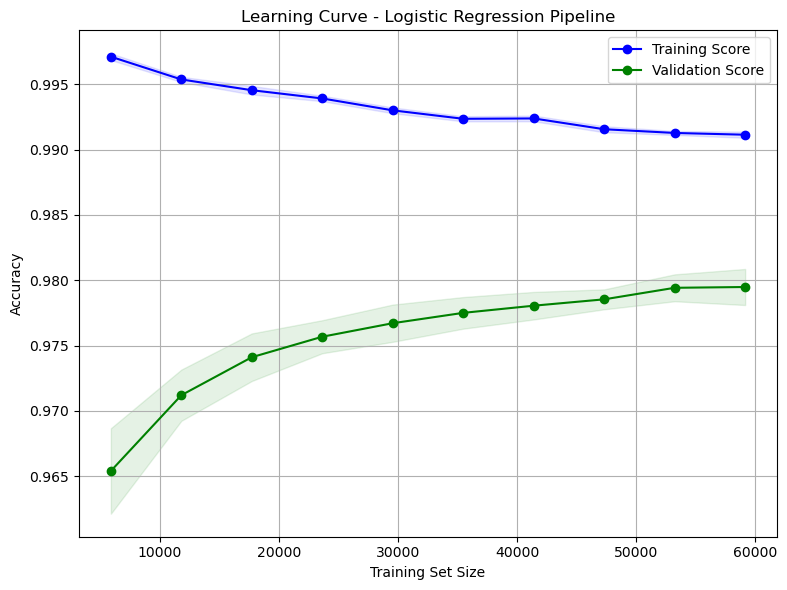

Exception ignored in: <function ResourceTracker.__del__ at 0x108233420>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1051ef420>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <fun

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_pipeline,
    X=X_train,
    y=y_train,
    cv=kfold,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Compute mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='green')
plt.title('Learning Curve - Logistic Regression Pipeline')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()